In [1]:
import numpy as np
import pandas as pd
import folium
from folium import plugins
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import re

warnings.filterwarnings("ignore")
from geopy.geocoders import Photon

geolocator = Photon(user_agent="measurements")

# Preprocessing

In [2]:
raw_call_data = pd.read_csv("311-2016-2018.csv")
raw_call_data.head(10)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Created Year
0,38237851,01/17/2018 02:39:00 PM,01/24/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,11222,95 GREENPOINT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.730013,-73.956267,"(40.73001299919553, -73.95626650502489)",2018.0
1,38237852,01/17/2018 01:40:00 PM,01/21/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,10308,40 ASHWOOD COURT,...,NaN,NaN,NaN,NaN,NaN,NaN,40.558494,-74.141962,"(40.558494382393974, -74.14196245468202)",2018.0
2,38237855,01/17/2018 10:42:00 PM,01/20/2018 10:02:00 PM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,11361,204-36 47 ROAD,...,NaN,NaN,NaN,NaN,NaN,NaN,40.754075,-73.775594,"(40.75407455058778, -73.77559379608053)",2018.0
3,38237856,01/17/2018 07:26:00 PM,01/19/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,10467,3851 BARNES AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.884181,-73.859111,"(40.88418051177941, -73.85911054646147)",2018.0
4,38237857,01/17/2018 07:13:00 PM,01/20/2018 07:41:00 PM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,11215,160 7 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.672113,-73.977242,"(40.67211272839247, -73.97724198791173)",2018.0
5,38237858,01/17/2018 06:58:00 PM,01/18/2018 10:00:00 PM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,11201,108 BALTIC STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.688114,-74.000184,"(40.68811426188034, -74.00018389626699)",2018.0
6,38237859,01/17/2018 05:01:00 PM,01/21/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,11213,921 ST MARKS AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.674727,-73.941122,"(40.67472666394193, -73.94112174167648)",2018.0
7,38237860,01/17/2018 03:28:00 PM,01/21/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,10466,1167 EAST 224 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.882667,-73.847632,"(40.882667327405926, -73.84763179136708)",2018.0
8,38237861,01/17/2018 02:30:00 PM,01/23/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,10031,608 WEST 140 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.823467,-73.953275,"(40.82346737209321, -73.953274825472)",2018.0
9,38237862,01/17/2018 02:29:00 PM,01/19/2018 08:34:00 PM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,Sidewalk,11215,706 UNION STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.676137,-73.979779,"(40.67613704270129, -73.97977864848177)",2018.0


In [3]:
# Select features of interest
features = ["Unique Key", "Created Date", "Agency", "Complaint Type", "Descriptor", "Borough", "Latitude", "Longitude"]
raw_call_data_pf = raw_call_data[features]
# Transorm Day, Month and Year to a Date
raw_call_data_pf["Day"] = raw_call_data_pf.apply(lambda x: datetime.datetime(int(x["Created Date"][6:10]), int(x["Created Date"][:2]), int(x["Created Date"][3:5])), axis=1)
raw_call_data_pf.drop(["Created Date"], axis=1, inplace=True)

In [4]:
# Remove data with mislabed borough 
raw_call_data_bo = raw_call_data_pf[(raw_call_data_pf["Borough"] != "Unspecified") & (raw_call_data_pf["Borough"] != "2016") & (raw_call_data_pf["Borough"] != "2017")]

In [5]:
# Save the data
raw_call_data_bo["Day"] = pd.to_datetime(raw_call_data_bo["Day"])
raw_call_data_bo.to_csv("311_calls_data.csv", index=False)

# Analysis and Visualization

### Group By Borough

In [6]:
raw_call_data_whole = raw_call_data_bo.copy()
raw_call_data_whole["count"] = 1
whole_df = raw_call_data_whole[["Day", "count"]].groupby("Day", as_index=False).count().sort_values("Day")

Text(0.5, 0, '')

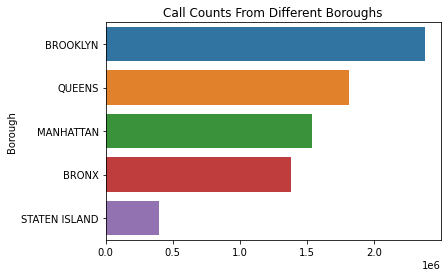

In [7]:
borough_counts = raw_call_data_whole["Borough"].value_counts()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(y=raw_call_data_whole["Borough"], order=borough_counts.index)
ax.set_title('Call Counts From Different Boroughs', fontsize = 12)
ax.set_xlabel("", fontsize = 12)

### Group By Day

In [8]:
tmp_df = raw_call_data_bo[raw_call_data_bo["Day"] == datetime.datetime(2018, 1, 1)].dropna().reset_index(drop=True).reset_index(drop=True)
call_location = tmp_df[["Latitude", "Longitude"]]
map = folium.Map(location=[call_location.Latitude.mean(), call_location.Longitude.mean()], zoom_start=10, control_scale=True)

plugins.HeatMap(list(zip(tmp_df["Latitude"], tmp_df["Longitude"])), radius=15, min_opacity=0.2).add_to(map)
map### Group By Borough

Text(0.5, 1.0, 'Counts of Inbound 311 Calls')

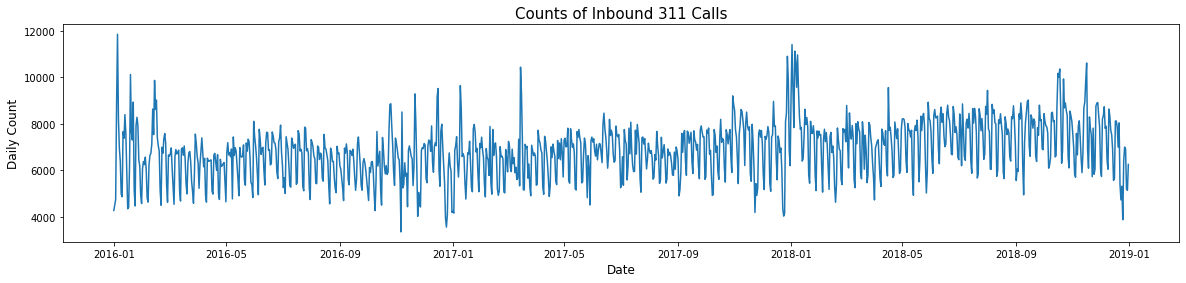

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
sns.lineplot(x=whole_df["Day"], y=whole_df["count"])
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel('Daily Count', fontsize=12)
ax.set_title("Counts of Inbound 311 Calls", fontsize=15)

Text(0.5, 1.0, 'Histogram of call counts')

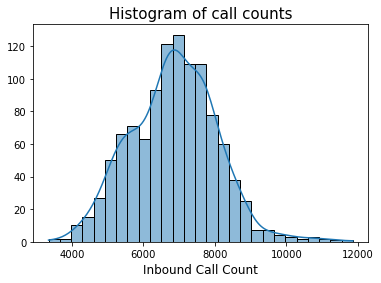

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(whole_df["count"], kde=True, ax=ax)
ax.set_xlabel('Inbound Call Count', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.set_title("Histogram of call counts", fontsize=15)

### Group By Agency Name

<AxesSubplot:xlabel='count', ylabel='Agency Name'>

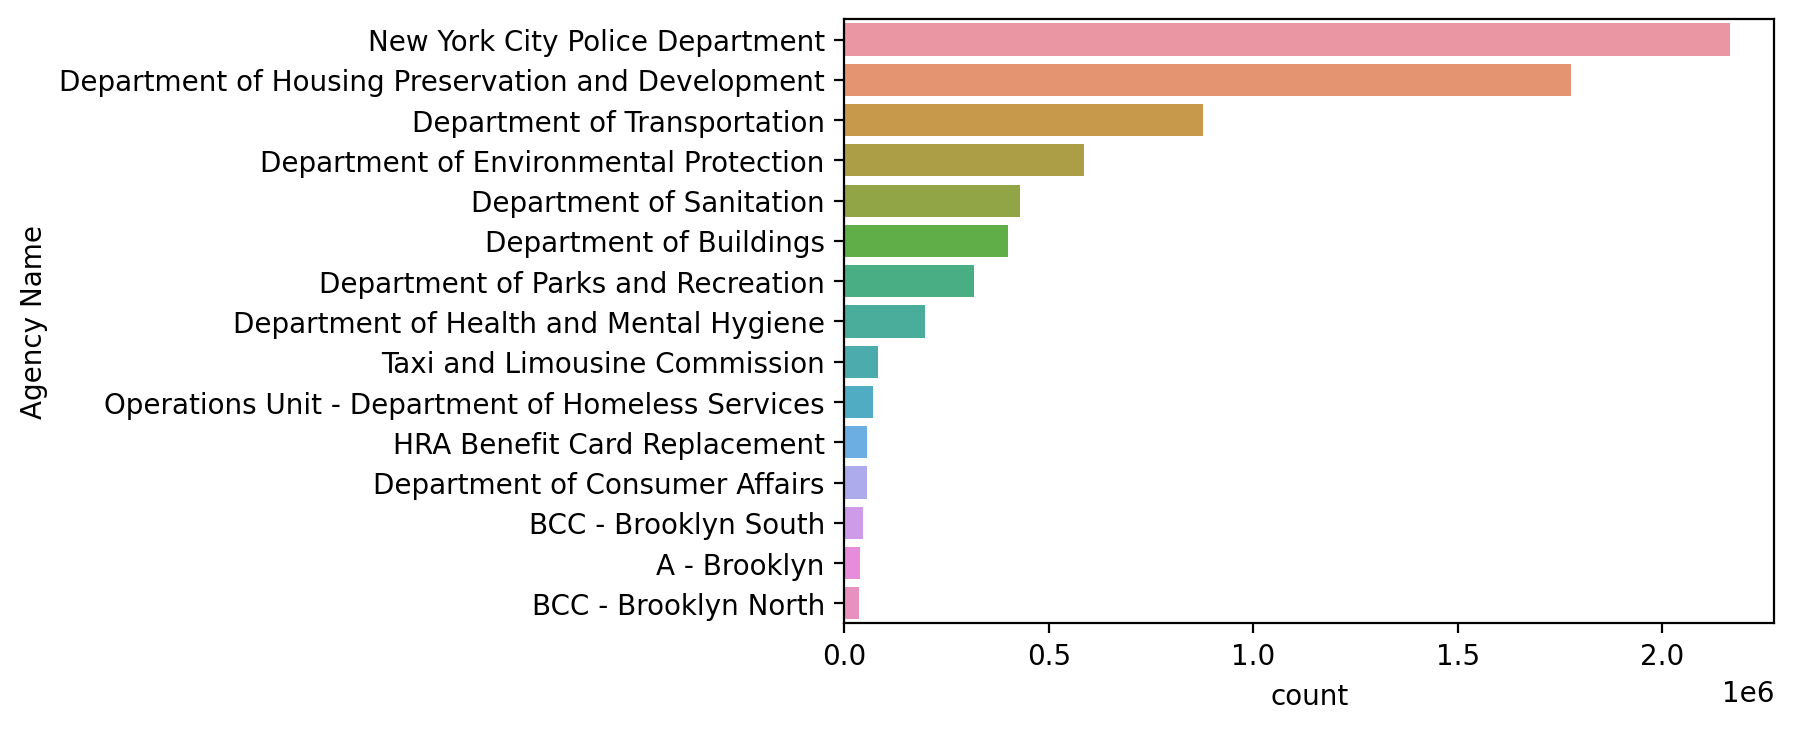

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi= 200)
sns.countplot(y=raw_call_data["Agency Name"], order=raw_call_data["Agency Name"].value_counts()[:15].index,ax =ax)

### Group By Complaint

In [12]:
### Group By Boroughraw_call_data["Complaint Type"].value_counts()[:20].index

In [13]:
# Clean the complaint column
complaint_replace_dic = {
    "Noise - Residential": "Noise",
    "Noise - Vehicle": "Noise",
    "Noise - Commercial": "Noise",
    "Noise - Street/Sidewalk": "Noise",
    "Noise - Park": "Noise",
    "Noise - House of Worship": "Noise",
    "Noise - Helicopter": "Noise",
    "Collection Truck Noise": "Noise",
    "UNSANITARY CONDITION": "Sanitation Condition",
    "HEAT/HOT WATER": "Heat/Hot Water",
    "PAINT/PLASTER": "Paint/Plaster",
    "DOOR/WINDOW": "Door/Window",
    "PLUMBING": "General Construction/Plumbing",
}

In [14]:
tmp_col = raw_call_data["Complaint Type"].replace(complaint_replace_dic)

Text(0.5, 1.0, 'Top 15 Complaint Types')

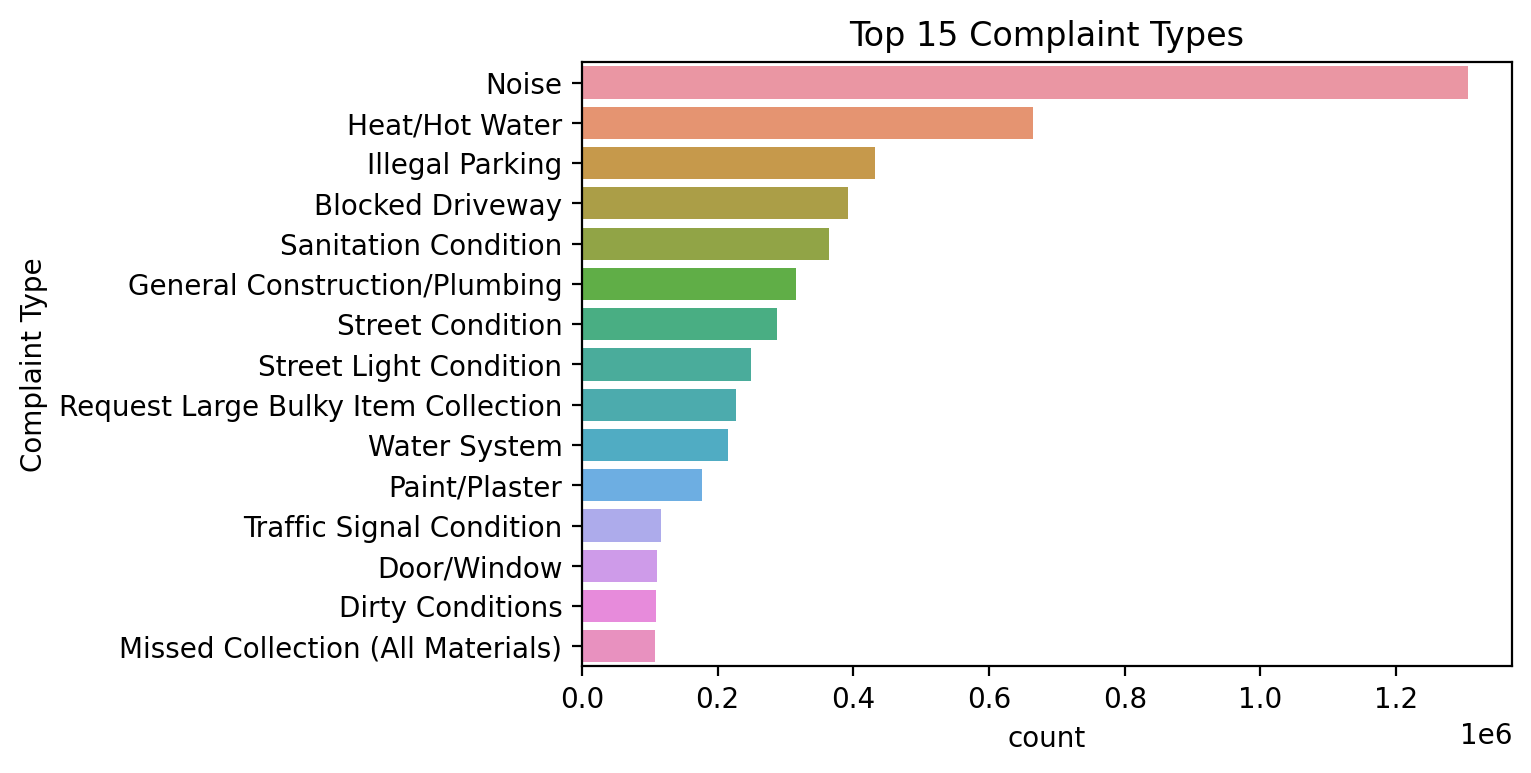

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi= 200)
sns.countplot(y=tmp_col, order=tmp_col.value_counts()[:15].index)
ax.set_title('Top 15 Complaint Types')